# Broadcasting

Goal is to write a blog around broadcasting around pytorch which is backbone of deeplearning.

## The Need for Broadcasting

1. **Efficiency in Operations**: Without broadcasting, you'd need to manually resize arrays to perform operations between differently shaped tensors. This would require writing explicit loops or creating temporary copies of data, both of which are inefficient.

2. **Code Readability**: Imagine having to write nested loops every time you want to add a scalar to each element in a matrix, or add corresponding elements of arrays with different dimensions. Your code would become cluttered and harder to understand.

3. **Memory Optimization**: Broadcasting allows operations without actually duplicating the data in memory. This is crucial when working with large tensors in deep learning.

In [1]:
import torch 

A = torch.randn((256, 128))
B = torch.randn((128, 64))

In [2]:
#| hide
ar, ac = A.shape
br, bc = B.shape

### Using loops
Ofcourse we can simply do A.matmul(B) but we want to learn broadcasting. 
Lets start by a traditional approach i.e. loops.


In [3]:
#| hide
C = torch.zeros((ar, bc))
C.shape

torch.Size([256, 64])

In [4]:
#| hide
for i in range(ar):
    for j in range(bc):
        temp = 0.
        for k in range(ac):
            temp += A[i,k]* B[k, j]
        C[i,j] = temp

In [5]:
def mul1(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros((ar, bc))

    for i in range(ar):
        for j in range(bc):
            temp = 0.
            for k in range(ac):
                temp += a[i,k]* b[k, j]
            c[i,j] = temp
    
    return c

In [6]:
%time
c = mul1(A, B)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


## Removing innermost loop

In [7]:
#| hide
A[0,:].shape, B[:,0].shape

(torch.Size([128]), torch.Size([128]))

In [8]:
#| hide
(A[0,:]*B[:,0]).shape

torch.Size([128])

In [9]:
def mul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros((ar, bc))

    for i in range(ar):
        for j in range(bc):
            
            c[i,j] = torch.sum(a[i,:]*b[:,j])
    
    return c

In [20]:
assert torch.allclose(c, mul2(A, B),  rtol=1e-2) ## for checking if the result are same

In [11]:
%time
_ = mul2(A, B)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.6 µs


**Rules for broadcasting**<br>
PyTorch compares the shapes element-wise, starting from the rightmost dimension
Dimensions are compatible when:
- They are equal, or
- One of them is 1 (which gets "stretched"), or
- One doesn't exist (which gets "added" as a dimension of size 1)

In [12]:
T = torch.randn((3))
S = torch.tensor(5)

T.shape, S.shape

(torch.Size([3]), torch.Size([]))

In [13]:
#| hide
import graphviz

# Create the directed graph
flow = graphviz.Digraph('broadcasting_flow', comment='Broadcasting Flow Diagram')

# Node definitions
flow.attr('node', shape='box', style='filled', color='lightblue')

# Start with input tensors
flow.node('input1', 'Tensor T\nShape: (3)')
flow.node('input2', 'Scalar S\nShape: ()')

# Broadcasting process nodes
flow.node('compare', 'Compare shapes\nright-to-left')
flow.node('expand', 'Virtual expansion\nof scalar S')
flow.node('virtual', 'Virtual tensor\nS repeated 3 times\nShape: (3)')
flow.node('operation', 'Element-wise\nmultiplication')
flow.node('result', 'Result tensor\nShape: (3)')

# Edges showing the flow
flow.edge('input1', 'compare')
flow.edge('input2', 'compare')
flow.edge('compare', 'expand')
flow.edge('expand', 'virtual')
flow.edge('input1', 'operation')
flow.edge('virtual', 'operation')
flow.edge('operation', 'result')
flow.render('broadcasting_flow', format='png', cleanup=True)


'broadcasting_flow.png'

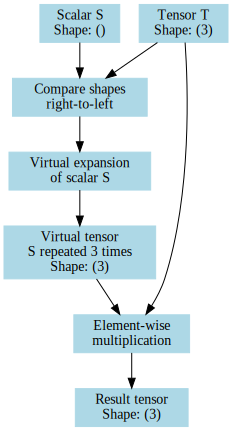

In [14]:
flow

In [15]:
#| hide
(A[1] @ B).shape

torch.Size([64])

## With only one loop

In [16]:
def mul3(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros((ar, bc))

    for i in range(ar):
        c[i] = A[i] @ B  # dim[128] * dim[128,64]
    return c

In [17]:
assert torch.allclose(c, mul3(A, B),  rtol=1e-2) 

In [18]:
%time
_ = mul3(A, B)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


## matrix multiplication
best and fastest

In [19]:
%time
_ = A @ B

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs
